In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import os

In [2]:
input_base_dir = 'BCS'

categories = ['belly pain', 'burping', 'cold_hot', 'discomfort', 'hungry', 'laugh', 'noise', 'silence', 'tired']

output_base_dir = 'BCS/spectrograms_filtered'

for category in categories:
    input_path = os.path.join(input_base_dir, category)
    output_path = os.path.join(output_base_dir, category)
    
    os.makedirs(output_path, exist_ok=True)
    
    if not os.path.exists(input_path):
        print(f"Warning: Input directory '{input_path}' does not exist")
        continue
    
    audio_files = [f for f in os.listdir(input_path) if f.endswith(('.wav', '.mp3', '.flac', '.ogg'))]
    
    if not audio_files:
        print(f"No audio files found in '{input_path}'")
        continue
    
    print(f"Processing {len(audio_files)} files from '{category}'...")
    
    for file in audio_files:
        filepath = os.path.join(input_path, file)
        
        try:
            y, sr = librosa.load(filepath, sr=22050)
            
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            S_db = librosa.power_to_db(S, ref=np.max)
            
            threshold = np.mean(S_db) + np.std(S_db)
            mask = S_db > threshold
            
            freq_indices = np.where(np.sum(mask, axis=1) > 0)[0]
            time_indices = np.where(np.sum(mask, axis=0) > 0)[0]
            
            if len(freq_indices) == 0 or len(time_indices) == 0:
                print(f"  Skipping {file} - no significant content")
                continue
            
            S_filtered = S_db[freq_indices, :]
            S_filtered = S_filtered[:, time_indices]
            
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(S_filtered, sr=sr, x_axis='time', y_axis='mel')
            plt.axis('off')
            
            output_filename = os.path.splitext(file)[0] + '.png'
            save_path = os.path.join(output_path, output_filename)
            plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
            plt.close()
            
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    print(f"Completed processing '{category}'")

print("\nAll categories processed with frequency filtering!")

Processing 124 files from 'belly pain'...
Completed processing 'belly pain'
Processing 108 files from 'burping'...
Completed processing 'burping'
Processing 108 files from 'cold_hot'...
Completed processing 'cold_hot'
Processing 135 files from 'discomfort'...
Completed processing 'discomfort'
Processing 382 files from 'hungry'...
Completed processing 'hungry'
Processing 108 files from 'laugh'...
Completed processing 'laugh'
Processing 108 files from 'noise'...
Completed processing 'noise'
Processing 108 files from 'silence'...
Completed processing 'silence'
Processing 132 files from 'tired'...
Completed processing 'tired'

All categories processed with frequency filtering!


In [3]:
import cv2
from sklearn.model_selection import train_test_split

spectrograms_dir = 'BCS/spectrograms_filtered'
categories = ['belly pain', 'burping', 'cold_hot', 'discomfort', 'hungry', 'laugh', 'noise', 'silence', 'tired']

X = []
y = []

print("Loading spectrogram images...")

class_counts = {}
for idx, category in enumerate(categories):
    category_path = os.path.join(spectrograms_dir, category)
    
    if not os.path.exists(category_path):
        print(f"Warning: Directory '{category_path}' does not exist")
        continue
    
    image_files = [f for f in os.listdir(category_path) if f.endswith('.png')]
    class_counts[category] = len(image_files)
    
    print(f"Loading {len(image_files)} images from '{category}'...")
    
    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        
        try:
            img = cv2.imread(image_path)
            
            if img is not None:
                img_resized = cv2.resize(img, (224, 224))
                X.append(img_resized)
                y.append(idx)
            else:
                print(f"Warning: Could not load {image_path}")
                
        except Exception as e:
            print(f"Error loading {image_file}: {str(e)}")

min_samples = min(class_counts.values())
print(f"\nMinimum samples per class: {min_samples}")
print("Balancing dataset to have equal samples per class...")

X_balanced = []
y_balanced = []

for idx, category in enumerate(categories):
    class_mask = np.array(y) == idx
    class_indices = np.where(class_mask)[0]
    
    np.random.seed(42)
    selected_indices = np.random.choice(class_indices, min_samples, replace=False)
    
    for i in selected_indices:
        X_balanced.append(X[i])
        y_balanced.append(y[i])

X = np.array(X_balanced)
y = np.array(y_balanced)

print(f"\nBalanced dataset created!")
print(f"Total samples: {len(X)}")
print(f"Samples per class: {min_samples}")
print(f"\nClass distribution:")
for idx, category in enumerate(categories):
    count = np.sum(y == idx)
    print(f"  {category}: {count} samples")

Loading spectrogram images...
Loading 124 images from 'belly pain'...
Loading 108 images from 'burping'...
Loading 108 images from 'cold_hot'...
Loading 135 images from 'discomfort'...
Loading 382 images from 'hungry'...
Loading 108 images from 'laugh'...
Loading 108 images from 'noise'...
Loading 108 images from 'silence'...
Loading 132 images from 'tired'...

Minimum samples per class: 108
Balancing dataset to have equal samples per class...

Balanced dataset created!
Total samples: 972
Samples per class: 108

Class distribution:
  belly pain: 108 samples
  burping: 108 samples
  cold_hot: 108 samples
  discomfort: 108 samples
  hungry: 108 samples
  laugh: 108 samples
  noise: 108 samples
  silence: 108 samples
  tired: 108 samples


In [4]:

# Convert to numpy arrays
# (Already converted above after balancing)

print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(X)}")
print(f"Image shape: {X[0].shape if len(X) > 0 else 'N/A'}")
print(f"Number of classes: {len(categories)}")
print(f"\nClass distribution:")
for idx, category in enumerate(categories):
    count = np.sum(y == idx)
    print(f"  {category}: {count} samples")

# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")


Dataset loaded successfully!
Total samples: 972
Image shape: (224, 224, 3)
Number of classes: 9

Class distribution:
  belly pain: 108 samples
  burping: 108 samples
  cold_hot: 108 samples
  discomfort: 108 samples
  hungry: 108 samples
  laugh: 108 samples
  noise: 108 samples
  silence: 108 samples
  tired: 108 samples

Training set: 777 samples
Testing set: 195 samples


Preparing data for SVM...
Flattened training data shape: (777, 150528)
Flattened test data shape: (195, 150528)

Training SVM model...
Model training completed!

Evaluating model on training set...
Train Accuracy: 0.7194 (71.94%)

Evaluating model on test set...
Test Accuracy: 0.3282 (32.82%)

Classification Report:
              precision    recall  f1-score   support

  belly pain       0.31      0.50      0.38        22
     burping       0.11      0.05      0.07        21
    cold_hot       0.16      0.23      0.19        22
  discomfort       0.13      0.18      0.15        22
      hungry       0.06      0.05      0.05        22
       laugh       0.54      0.67      0.60        21
       noise       0.45      0.23      0.30        22
     silence       1.00      1.00      1.00        21
       tired       0.14      0.09      0.11        22

    accuracy                           0.33       195
   macro avg       0.32      0.33      0.32       195
weighted avg       0.32      0.3

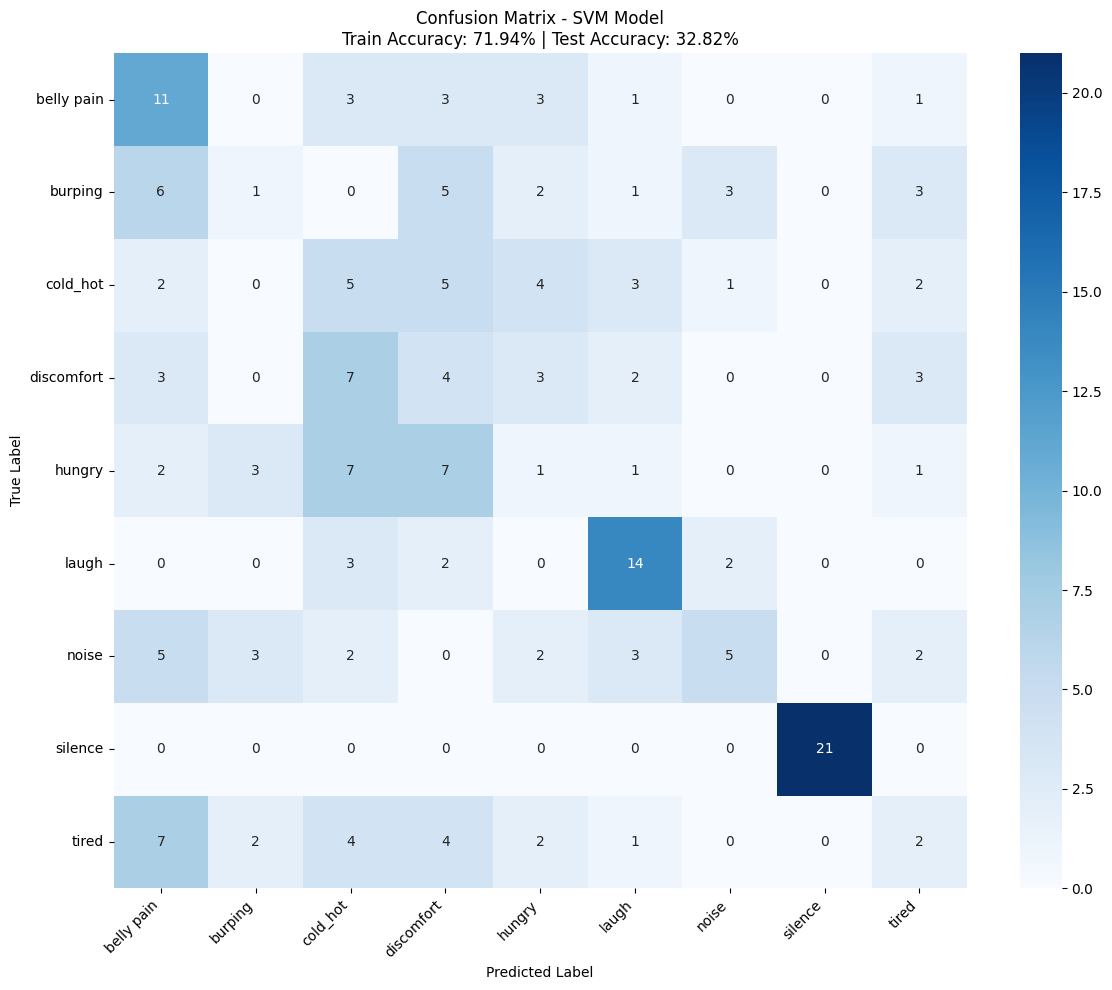


Per-class Accuracy:
  belly pain: 0.5000 (50.00%)
  burping: 0.0476 (4.76%)
  cold_hot: 0.2273 (22.73%)
  discomfort: 0.1818 (18.18%)
  hungry: 0.0455 (4.55%)
  laugh: 0.6667 (66.67%)
  noise: 0.2273 (22.73%)
  silence: 1.0000 (100.00%)
  tired: 0.0909 (9.09%)


In [5]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("Preparing data for SVM...")

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")

print("\nTraining SVM model...")

svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_flat, y_train)

print("Model training completed!")

print("\nEvaluating model on training set...")
y_train_pred = svm.predict(X_train_flat)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

print("\nEvaluating model on test set...")
y_pred = svm.predict(X_test_flat)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories)
plt.title(f'Confusion Matrix - SVM Model\nTrain Accuracy: {train_accuracy:.2%} | Test Accuracy: {test_accuracy:.2%}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nPer-class Accuracy:")
for idx, category in enumerate(categories):
    class_mask = y_test == idx
    if np.sum(class_mask) > 0:
        class_accuracy = accuracy_score(y_test[class_mask], y_pred[class_mask])
        print(f"  {category}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")